<a href="https://colab.research.google.com/github/chw8207/Transformer/blob/main/BERT%EB%AA%A8%EB%8D%B8_%EB%AF%B8%EC%84%B8%EC%A1%B0%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch

In [ ]:
pip install transformers

In [ ]:
pip install tensorflow

In [ ]:
pip install --upgrade pip

In [ ]:
pip install keras_preprocessing

In [58]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,\
SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertModel
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import matthews_corrcoef
%matplotlib inline

### gpu 설정

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [9]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11162876881262948201
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40129593344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16837727636327572563
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


### CUDA를 Torch용 디바이스로 지정하기

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'NVIDIA A100-SXM4-40GB'

In [11]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

### 데이터셋 로드하기

In [13]:
#@title Loading the Dataset
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/트랜스포머/Trasnformer/Transformer/data/in_domain_train.tsv', delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [14]:
# 1열 : 문장의 출처를 나타내는 코드
# 2열 : 수용성 판단 레이블(0=수용불가, 1=수용가능)
# 3열 : 작성자가 붙인 수용성 판단
# 4열 : 분류 대상 문장
df.sample(10)

,sentence_source,label,label_notes,sentence
20,gj04,0,*,the professor talked us .
3255,l-93,1,NaN,idaho potatoes bake beautifully .
7851,ad03,0,*,can he will do it ?
1374,r-67,1,NaN,sheila married that tall a man .
1329,r-67,1,NaN,harry will be in the marines next year and her...
5865,c_13,1,NaN,eloise wants you to study a new language . ass...
5989,c_13,1,NaN,has bill eaten his tuna ?
7071,sgww85,1,NaN,we americans and the british pamper ourselves .
8346,ad03,1,NaN,julie and jenny arrived first
5341,b_73,1,NaN,i am more angry than sad .


### 문장 및 레이블 목록 생성, BERT토큰 추가

In [15]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values

# BERT를 위한 각 문장 시작에 CLS를, 그리고 각 문장 끝에 SEP를 추가함
sentences = ['[CLS]' + sentence + '[SEP]' for sentence in sentences]
labels = df.label.values

### BERT 토크나이저 활성화

In [17]:
!git clone https://huggingface.co/bert-base-uncased

Cloning into 'bert-base-uncased'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 80
Unpacking objects: 100% (82/82), 330.01 KiB | 739.00 KiB/s, done.
Filtering content: 100% (7/7), 3.21 GiB | 158.39 MiB/s, done.


In [18]:
#@title Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('./bert-base-uncased/', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print('Tokenize the first sentences:')
print(tokenized_texts)

Tokenize the first sentences:
[['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]'], ['[CLS]', 'one', 'more', 'pseudo', 'general', '##ization', 'and', 'i', "'", 'm', 'giving', 'up', '.', '[SEP]'], ['[CLS]', 'one', 'more', 'pseudo', 'general', '##ization', 'or', 'i', "'", 'm', 'giving', 'up', '.', '[SEP]'], ['[CLS]', 'the', 'more', 'we', 'study', 'verbs', ',', 'the', 'cr', '##azi', '##er', 'they', 'get', '.', '[SEP]'], ['[CLS]', 'day', 'by', 'day', 'the', 'facts', 'are', 'getting', 'mu', '##rk', '##ier', '.', '[SEP]'], ['[CLS]', 'i', "'", 'll', 'fix', 'you', 'a', 'drink', '.', '[SEP]'], ['[CLS]', 'fred', 'watered', 'the', 'plants', 'flat', '.', '[SEP]'], ['[CLS]', 'bill', 'coughed', 'his', 'way', 'out', 'of', 'the', 'restaurant', '.', '[SEP]'], ['[CLS]', 'we', "'", 're', 'dancing', 'the', 'night', 'away', '.', '[SEP]'], ['[CLS]', 'herman', 'hammered', 'the', 'metal', 'flat', '.', '[SEP]'], [

### 데이터 처리
- 고정된 최대 길이 : 512
- 시퀀스는 패딩됨.

In [19]:
#@title Processing the data
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 입력 토큰에 패딩 적용하기
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post",
                          padding="post")

### 어텐션 마스크 생성하기

In [20]:
# 패딩된 토큰에 attention을 적용하지 않고 싶음
# 각 토큰에 대해 값이 1인 마스크 적용하고
# 패딩에는 0이 부여됨.
#@title Create attention masks
attention_masks = []

for seq in input_ids :
    # i>0 : True이면 1, False이면 0 반환
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [21]:
attention_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

### 훈련 및 검증 데이터 분리하기

In [22]:
train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids, random_state=2018,
                                                       test_size=0.1)

### Torch 텐서로 데이터 변환

In [23]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### 배치 크기 선택 및 iteratior 생성하기

In [24]:
batch_size = 20

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### BERT 모델 설정

In [25]:
# 트랜스포머 설치
try :
    import transformers
except :
    print('Installing transformers')
    !pip -qq install transformers

In [26]:
configuration = BertConfig()

# 모델 초기화
model = BertModel(configuration)

# 모델 configuration에 접근하기
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



### Hugging Face BERT uncased 베이스 모델 불러오기

In [ ]:
# # gpu 캐시 비워주기
# gc.collect()
# torch.cuda.empty_cache()

In [27]:
model = BertForSequenceClassification.from_pretrained('./bert-base-uncased/',
                                                      num_labels=2)
model.cuda()

Some weights of the model checkpoint at ./bert-base-uncased/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./bert-base-uncased/ and are n

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### optimizer 그룹 파라미터

In [28]:

##@title Optimizer Grouped Parameters
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# bias파라미터로부터 weight파라미터 분리하기
# weigth : 가중치 감쇠율 = 0.01
# bias : 가중치 감쇠율 = 0.0
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rage': 0.00}
]

### 훈련 루프용 하이퍼파라미터

In [29]:
epochs = 4
optimzier = torch.optim.AdamW(optimizer_grouped_parameters,
                              lr = 2e-5, # arg.learning_rate : 기본값 = 5e-6
                              eps=1e-8   # args.adam_epsilon : 기본값 : 1e-8
                              )

total_steps = len(train_dataloader) * epochs

# 학습률 스케줄러 만들기
scheduler = get_linear_schedule_with_warmup(optimzier,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [30]:
# 정확도 측정 함수 만들기
def flat_accuracy(preds, labels) :
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### 훈련 루프

In [31]:
t = []
# plotting을 위한 loss와 정확도 저장
train_loss_set = []

epochs = 4

for _ in trange(epochs, desc='Epoch') :
    # 훈련
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # 한 에포크 데이터 훈련
    for step, batch in enumerate(train_dataloader) :
        # GPU에 장치 추가
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_masks, b_labels = batch

        # 그레디언트 claer out
        optimzier.zero_grad()
        # 순방향 전파
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_masks,
                         labels=b_labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())

        # 역전파
        loss.backward()
        # 파라미터 업데이터
        optimzier.step()
        # 학습률 업데이트
        scheduler.step()

        # 트래킹 변수 업데이트
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print(f'Train loss: {tr_loss/nb_tr_steps}')


Epoch:  25%|██▌       | 1/4 [00:42<02:08, 42.85s/it]

Train loss: 0.4911601073169089


Epoch:  50%|█████     | 2/4 [01:22<01:21, 40.91s/it]

Train loss: 0.2823660157040342


Epoch:  75%|███████▌  | 3/4 [02:01<00:40, 40.28s/it]

Train loss: 0.14880677387844046


Epoch: 100%|██████████| 4/4 [02:41<00:00, 40.35s/it]

Train loss: 0.08581885377719224


### 훈련 평가

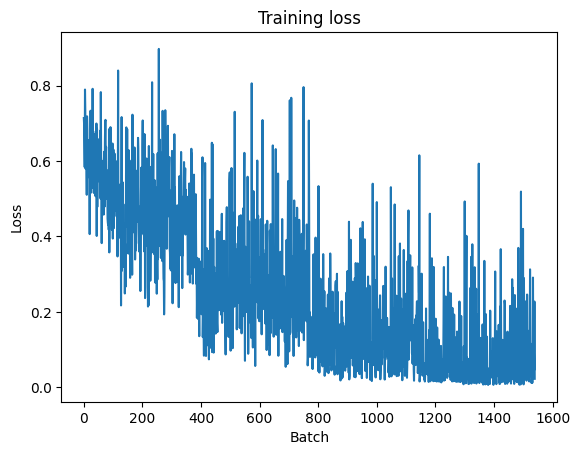

In [36]:
plt.plot(figsize=(15,8))
plt.title('Training loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.plot(train_loss_set)
plt.show()

### 미사용 데이터셋에 의한 예측 및 평가

In [51]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/트랜스포머/Trasnformer/Transformer/data/out_of_domain_dev.tsv',
                 delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

# 문장과 label 리스트 생성하기
sentences = df.sentence.values

# BERT를 위한 특별한 토큰 추가하기
sentences = ['[CLS]' + sentence + '[SEP]' for sentence in sentences]

labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128
# BERT토크나이저 사용
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# 입력 토큰에 패딩 적용
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long',
                          truncating='post', padding='post')
# 어텐션 마스크 생성하기
attention_masks = []

# 패딩된 토큰에 attention을 적용하지 않고 싶음
# 각 토큰에 대해 값이 1인 마스크 적용하고
# 패딩에는 0이 부여됨.
for seq in input_ids :
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 20

prediction_data = TensorDataset(prediction_inputs, prediction_masks,
                                prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler,
                                   batch_size=batch_size)

#### 테스트셋에 대한 예측

In [55]:
model.eval()

# 변수 트래킹
predictions, true_labels = [], []

# 예측
for batch in prediction_dataloader :
  # GPU에 배치 추가하기
  batch = tuple(t.to(device) for t in batch)
  # 입력 언팩킹
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients,
  # saving memory and speeding up prediction
  with torch.no_grad() :
    # 포워드 pass, 로짓 예측 계산
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # 예측의 로짓과 레이블 값들이 CPU로 이동함
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # 예측 및 실제 레이블이 저장됨
  predictions.append(logits)
  true_labels.append(label_ids)

### Matthews 상관계수에 의한 평가

In [60]:
# 일련의 예측 생성
matthews_set = []

# MCC값이 계산되고 저장됨
for i in range(len(true_labels)) :
  matthews = matthews_corrcoef(true_labels[i],
                               np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [61]:
# 개별 배치 점수
matthews_set

[0.0,
 0.0,
 -0.18156825980064073,
 -0.2075143391598224,
 0.7035264706814485,
 0.19245008972987526,
 -0.2721655269759087,
 0.8660254037844386,
 0.5790660241435861,
 0.7071067811865475,
 0.5604395604395604,
 0.35043832202523123,
 1.0,
 -0.05263157894736842,
 0.7385489458759964,
 0.7916666666666666,
 0.8819171036881969,
 0.7276068751089989,
 0.7333333333333333,
 0.816496580927726,
 1.0,
 1.0,
 0.49099025303098287,
 0.375,
 0.4923659639173309,
 0.53748384988657]

In [78]:
# 전체 데이터셋에 대한 Matthews 평가
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5404323554886978